Theory Questions:

Q1: The minimax loss function in GANs is the function used to evaluate the ability of the discriminator to classify between real and fake data as well as the ability of the generator to make the discriminator classify fake data as real data. The loss function is as follows:

$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)} [\log D(x)] + \mathbb{E}_{z \sim p_z(z)} [\log (1 - D(G(z)))]$

It is a two player minimax game where the discriminator and generator are trained adversarially in order to make the generator create images that are indistinguishable from real images.

Q2: Mode collapse is when the generator does not generate a diverse set of outputs that represent that full range of the dataset and instead repeatedly generates very similar outputs that only capture a small portion of the dataset. Mode collapse occurs because the generator is not being provided with accurate feedback through the loss function from the discriminator. The generator's task only becomes to find an output that can fool the discriminator to win the minimax game between the two instead of trying to generate the most realistic image that is representative of the dataset. This causes the generator to converge to a local max and repeatedly generate very similar outputs because the discriminator does not provide strong enough feedback. It can be mitigated with the Wasserstein GAN loss. This method assigns scores to the output of the generator instead of binary classification so the generator receives more accurate feedback. The WGAN loss also avoids the problem of vanishing gradients and incentivizes trying to match full distributions of data. Batch normalization and minibatch discrimination improves output diversity and provide smooth gradient updates as well.

Q3: The role of the discriminator is to assign a probability of how real or fake an image is. In adversarial training the discriminator's task is to correctly classify the two while the generator's task is to generate images that the discriminator classifies as real. Because the goals of the generator and discriminator are in opposition to each other, it is defined as adversarial training. The feedback from the discriminator helps the generator adjust in order to produce more realistic images capable of eventually fooling the discriminator until it cannot tell the difference between real images and images generated by the generator.

Q4: IS or Inception Score is a pre-trained neural network to evaluate the performance of GANs. The main factors of evaluation are how clearly classifiable the output images are, and how varied the output images are. This essentially measures the GAN model's ability to generate easily identifiable images that are varied. FID or Fréchet Inception Distance evaluates GAN performance by comparing the GAN learned distribution with the distribution of real data. This compares the features of the content and can identify mode collapse as well as images that look real but are quite different from the real dataset.

In [15]:
!pip install tensorflow --quiet

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [6]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE)

In [7]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = make_generator_model()

In [8]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = make_discriminator_model()

In [9]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [11]:
# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
# Show images every 10 epochs
def image_saving(model, epoch, num_images):
    results = model(num_images, training=False)
    results = (results + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))
    for i in range(results.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(results[i])
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}', fontsize=12)
    plt.show()

In [13]:
# Training loop
def train(dataset, epochs):
    for epoch in range(1, epochs + 1):
        for image_batch in dataset:
            train_step(image_batch)

        if epoch % 10 == 0:
            image_saving(generator, epoch, tf.random.normal([8, 100]))

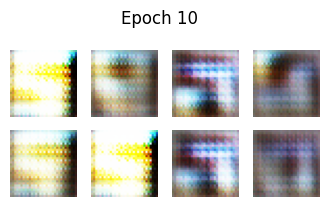

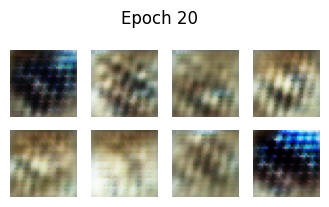

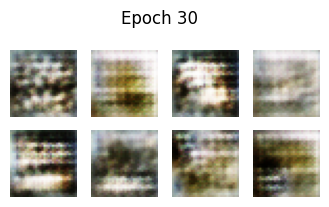

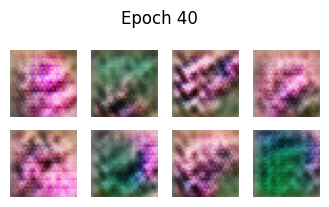

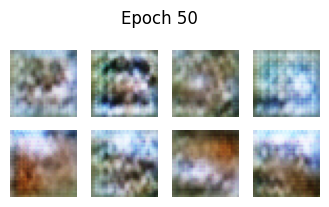

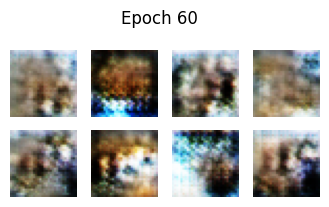

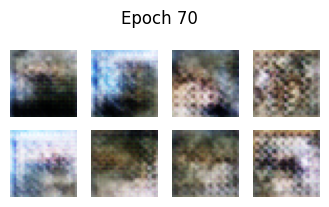

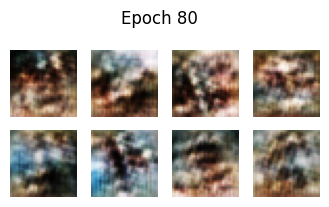

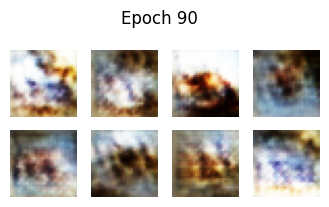

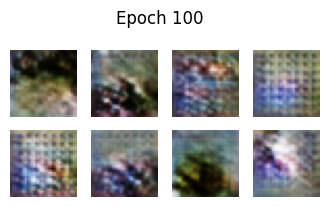

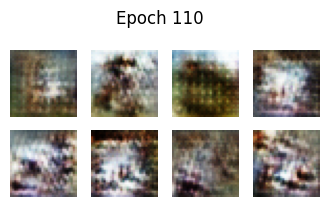

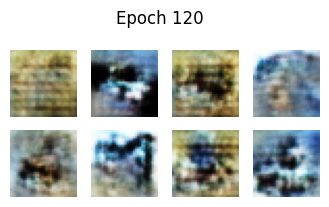

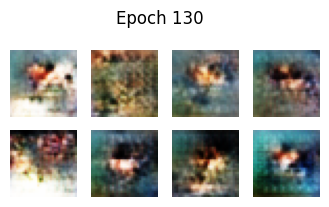

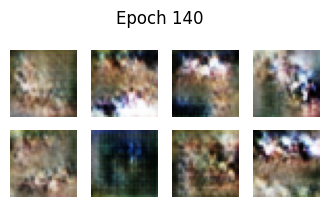

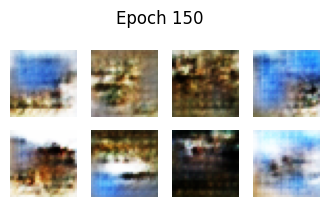

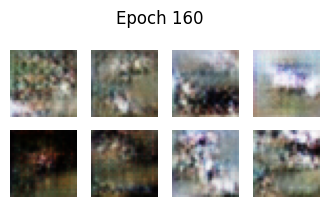

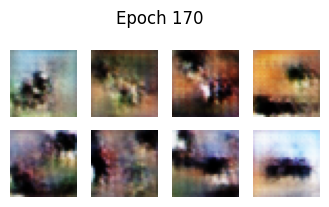

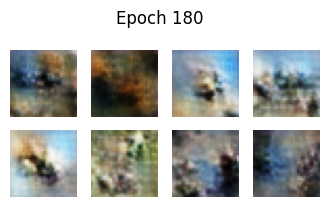

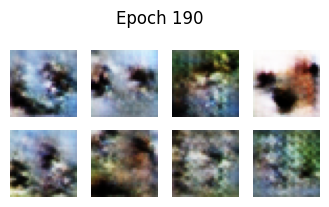

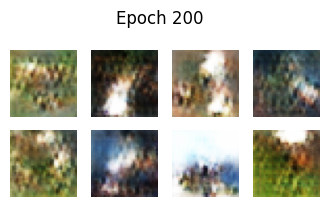

In [14]:
# Run the training
train(train_dataset, epochs=200)